# Global sensitivity analysis with parameterized datasets

This notebook builds on the companion notebook `Uncertainty assessment with parameterized datasets and presamples`; you should have read and understood that one before starting this.

Make sure you have the latest versions of bw2calc, presamples, bw2parameters, etc.!

We start by setting up a parameterized foreground database which builds on top of ecoinvent. You *must* have ecoinvent 3.4, cutoff system model, installed, and it *must* be called `"ecoinvent 3.4 cutoff"`.

In [1]:
%matplotlib inline

In [2]:
# For some reason I will fix later imports must be in this order
import brightway2 as bw
import presamples
import matplotlib.pyplot as plt
import numpy as np
import pyprind

We also have an example parameterized foreground database. This model is *made up*, and obviously silly.

In [3]:
bw.projects.set_current("Parameterized foreground GSA")

In [4]:
db = bw.Database("ecoinvent 3.4 cutoff")
assert len(db), "must install ecoinvent"
assert len(bw.Database("biosphere3")), "must run bw2setup"
assert len(bw.methods), "must run bw2setup"

In [5]:
e = bw.ExcelImporter("parameterized-foreground.xlsx")
e.apply_strategies()
e.match_database("ecoinvent 3.4 cutoff", fields=('name', 'location'))
e.match_database("ecoinvent 3.4 cutoff", fields=('name', 'location', 'reference product'))
e.match_database(fields=["name"])
e.statistics()

Extracted 1 worksheets in 0.01 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applied 15 strategies in 0.25 seconds
Applying strategy: link_iterable_by_fields
Couldn't apply strategy link_iterable_by_fields:
	Object in source database can't be uniquely linked to target database.
Problematic dataset is:
{'filename': '(missing)', 'location': 'R

(3, 7, 0)

In [6]:
e.write_database()

Writing activities to SQLite3 database:
0%  100%
[###] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/14/2018 15:34:36
  Finished: 05/14/2018 15:34:36
  Total time elapsed: 00:00:00
  CPU %: 121.10
  Memory %: 0.58
Created database: Weekend break


Generate presampled values of our variables and exchanges

In [7]:
from presamples.models import ParameterizedBrightwayModel

In [8]:
model = ParameterizedBrightwayModel("weekend_trip_gsa")           # Name of parameter group
model.load_parameter_data()                                       # Load data from parameters database
model.calculate_stochastic(iterations=1000, update_amounts=True)  # 1000 Monte Carlo iterations; keep results
model.calculate_matrix_presamples()                               # Transform results to be useful in LCA calculations
_, filepath = model.save_presample("gsa_example") 

In [9]:
filepath

PosixPath('/Users/cmutel/Library/Application Support/Brightway3/Parameterized-foreground-GSA.1ce37c4de59056c11cd7b47e75414782/presamples/d1780222b4124abe8c820dd2957d9964')

In [4]:
filepath = '<insert your value here in case you have to restart the notebook>'

# Global Sensitivity Analysis

We will use the technique of [Plischke et al 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995) as implemented in [SALib](http://joss.theoj.org/papers/431262803744581c1d4b6a95892d3343). The advantage of this technique is that it doesn't require a specific sampling strategy.

We adapt [the implementation of Plischke from SALib](https://github.com/SALib/SALib/blob/master/SALib/analyze/delta.py) for our input data structure.

In [10]:
from scipy.stats import gaussian_kde, rankdata, norm

def analyze(X, Y, num_resamples=10, conf_level=0.95):
    """Perform Delta Moment-Independent Analysis on model outputs.
    
    Returns a dictionary with keys 'delta', 'delta_conf', 'S1', and 'S1_conf',
    where each entry is a list of size D (the number of parameters) containing
    the indices in the same order as the parameter file.
    
    Parameters
    ----------
    X: A NumPy array containing the model inputs. Parameters are columns, samples are rows.
    Y : A NumPy array containing the model outputs
    num_resamples : int
        The number of bootstrap resamples when computing confidence intervals (default 10)
    conf_level : float
        The confidence interval level (default 0.95)
        
    References
    ----------
    .. [1] Borgonovo, E. (2007). "A new uncertainty importance measure."
           Reliability Engineering & System Safety, 92(6):771-784,
           doi:10.1016/j.ress.2006.04.015.
           
    .. [2] Plischke, E., E. Borgonovo, and C. L. Smith (2013). "Global
           sensitivity measures from given data." European Journal of
           Operational Research, 226(3):536-550, doi:10.1016/j.ejor.2012.11.047.
           
    """

    D = X.shape[1]
    N = Y.size

    if not 0 < conf_level < 1:
        raise RuntimeError("Confidence level must be between 0-1.")

    # equal frequency partition
    M = min(np.ceil(N ** (2 / (7 + np.tanh((1500 - N) / 500)))), 48)
    m = np.linspace(0, N, M + 1)
    Ygrid = np.linspace(np.min(Y), np.max(Y), 100)

    keys = ('delta', 'delta_conf', 'S1', 'S1_conf')
    S = dict((k, np.zeros(D)) for k in keys)

    for i in range(D):
        S['delta'][i], S['delta_conf'][i] = bias_reduced_delta(
            Y, Ygrid, X[:, i], m, num_resamples, conf_level)
        S['S1'][i] = sobol_first(Y, X[:, i], m)
        S['S1_conf'][i] = sobol_first_conf(
            Y, X[:, i], m, num_resamples, conf_level)

    return S

# Plischke et al. 2013 estimator (eqn 26) for d_hat

def calc_delta(Y, Ygrid, X, m):
    N = len(Y)
    fy = gaussian_kde(Y, bw_method='silverman')(Ygrid)
    xr = rankdata(X, method='ordinal')

    d_hat = 0
    for j in range(len(m) - 1):
        ix = np.where((xr > m[j]) & (xr <= m[j + 1]))[0]
        nm = len(ix)
        fyc = gaussian_kde(Y[ix], bw_method='silverman')(Ygrid)
        d_hat += (nm / (2 * N)) * np.trapz(np.abs(fy - fyc), Ygrid)

    return d_hat

# Plischke et al. 2013 bias reduction technique (eqn 30)

def bias_reduced_delta(Y, Ygrid, X, m, num_resamples, conf_level):
    d = np.zeros(num_resamples)
    d_hat = calc_delta(Y, Ygrid, X, m)

    for i in range(num_resamples):
        r = np.random.randint(len(Y), size=len(Y))
        d[i] = calc_delta(Y[r], Ygrid, X[r], m)

    d = 2 * d_hat - d
    return (d.mean(), norm.ppf(0.5 + conf_level / 2) * d.std(ddof=1))


def sobol_first(Y, X, m):
    xr = rankdata(X, method='ordinal')
    Vi = 0
    N = len(Y)
    for j in range(len(m) - 1):
        ix = np.where((xr > m[j]) & (xr <= m[j + 1]))[0]
        nm = len(ix)
        Vi += (nm / N) * (Y[ix].mean() - Y.mean()) ** 2
    return Vi / np.var(Y)


def sobol_first_conf(Y, X, m, num_resamples, conf_level):
    s = np.zeros(num_resamples)

    for i in range(num_resamples):
        r = np.random.randint(len(Y), size=len(Y))
        s[i] = sobol_first(Y[r], X[r], m)

    return norm.ppf(0.5 + conf_level / 2) * s.std(ddof=1)

How do we define the inputs correctly? We don't want to assess all the uncertain parameters in ecoinvent, but we do want to include the named parameters in our foreground inventory, as well as the activities directly used by the foreground.

In [11]:
mc = bw.MonteCarloLCA(
    {("Weekend break", "break"): 1}, 
    ('ReCiPe Endpoint (E,A)', 'total', 'total'), 
    presamples=[filepath]
)
next(mc)

152.6685919681067

## GSA inputs: named parameters

To get named parameter values per Monte Carlo iteration, we can look at `mc.presamples.parameters`. This is a list (there can be more than one presample package provided), but we only need the first. The returned object acts like a dictionary:

In [12]:
dict(mc.presamples.parameters[0])

{'weekend_trip_gsa__food_consumed': 1.25,
 'weekend_trip_gsa__hungry': 1.523592727500889,
 'weekend_trip_gsa__transport_mode': 0.603626843078715,
 'weekend_trip_gsa__vegetarian': 0.4227666015676321}

## GSA inputs: technosphere and biosphere matrix values

Each study will make a different selection of exchange values to include. Here, we take only the technosphere and biosphere exchanges for the activities directly linked to our foreground database. You could make this selection by looking in the database, but we can also filter using the matrices themselves.

In [13]:
ra, rp, rb = mc.reverse_dict()

foreground_columns = [col for key, col in mc.activity_dict.items() if key[0] == "Weekend break"]
subtechnosphere = mc.technosphere_matrix[:, foreground_columns]
subtechnosphere

<14892x3 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [14]:
linked_ecoinvent_indices = [row for row in subtechnosphere.tocoo().row
                            if rp[row][0] != "Weekend break"]
linked_ecoinvent_indices

[8841, 10166, 13119]

However, we need to be a bit clever here (and maybe we should have used the database after all...); we sometimes switch back and forth between inputs, and the zero inputs won't show up. We need to do this procedure over many iterations to make sure we get the entire set of possible inputs.

In [15]:
ra, rp, rb = mc.reverse_dict()

def get_linked_ecoinvent_indices(mc):
    return {row for row in 
            mc.technosphere_matrix[:, [col for key, col in 
                                       mc.activity_dict.items() 
                                       if key[0] == "Weekend break"]
                                  ].tocoo().row
            if rp[row][0] != "Weekend break"}   

all_possible_inputs = set.union(*[get_linked_ecoinvent_indices(mc) for _ in zip(range(10), mc)])
all_possible_inputs

{3664, 6288, 8841, 10166, 13119}

Those of you paying extra-special attention will notice that we treated `mc` as an iterator *and* and input to the function - and some of you are probably rolling your eyes at the way we are changing global state. Fair enough! Don't try this at home, kids.

In any case, we have all five possible inputs, which agrees with what is in our Excel input sheet. We don't actually want the amount of each of these five inputs, as this is already captured in our named parameters. But we do want the inputs to these five activities, as well as their biosphere exchange values.

We don't have to worry about multiple iterations from now on, as these are already exchanges in ecoinvent, and will always have some values.

In [16]:
def get_rows_for_columns(cols, matrix):
    indices = []
    for col in cols:
        submatrix = matrix[:, col].tocoo()
        for row in submatrix.row:
            indices.append((row, col))
    return indices

In [17]:
technosphere_exchanges = get_rows_for_columns(all_possible_inputs, mc.technosphere_matrix)
biosphere_exchanges = get_rows_for_columns(all_possible_inputs, mc.biosphere_matrix)

However, just a tuple of two integers isn't all that helpful - let's change this into something more meaningful.

In [18]:
def get_exchange_label(row, col, matrix="technosphere"):
    if matrix == "biosphere":
        return (bw.get_activity(rb[row]), bw.get_activity(ra[col]))
    else:
        return (bw.get_activity(rp[row]), bw.get_activity(ra[col]))        

# Managing all uncertain parameters

We can create a class that manages our uncertain parameters and LCA values.

This is only one possible approach - it might not work for you! In any case, we need to provide the following into the GSA `analyze` function:

    X: A NumPy array containing the model inputs. Parameters are columns, samples are rows.
    Y : A NumPy array containing the model outputs

In [19]:
class GSAManager:
    def __init__(self, mc, technosphere_indices, biosphere_indices, iterations=1000):
        self.named_parameters = sorted(mc.presamples.parameters[0])
        self.technosphere_indices = technosphere_indices
        self.technosphere_labels = [get_exchange_label(x, y) for x, y in self.technosphere_indices]
        self.biosphere_indices = biosphere_indices
        self.biosphere_labels = [get_exchange_label(x, y, "biosphere") for x, y in self.biosphere_indices]
        self.results = np.zeros((iterations,))
        self.inputs = np.zeros((
            iterations, 
            sum([len(self.named_parameters), len(self.technosphere_labels), len(self.biosphere_labels)])
        ))
        self.index = 0
        self.mc = mc
    
    @property
    def labels(self):
        return self.named_parameters + self.technosphere_labels + self.biosphere_labels
    
    def calculate(self):
        for _ in pyprind.prog_bar(self.results):
            next(self.mc)
            self.add_iteration()    
        self.gsa()
            
    def add_iteration(self):
        if self.index >= self.inputs.shape[0]:
            raise ValueError
        self.results[self.index] = self.mc.score
        for i, j in enumerate(self.named_parameters):
            self.inputs[self.index, i] = self.mc.presamples.parameters[0][j]
        offset = i + 1
        for i, (r, c) in enumerate(self.technosphere_indices):
            self.inputs[self.index, i + offset] = self.mc.technosphere_matrix[r, c]
        offset += i + 1
        for i, (r, c) in enumerate(self.biosphere_indices):
            self.inputs[self.index, i + offset] = self.mc.biosphere_matrix[r, c]
        self.index += 1
    
    def gsa(self, num_resamples=10, conf_level=0.95):
        self.gsa_result = analyze(
            self.inputs, self.results, 
            num_resamples=num_resamples, conf_level=conf_level
        )

In [20]:
manager = GSAManager(mc, technosphere_exchanges, biosphere_exchanges, iterations=2500)

In [21]:
manager.calculate()

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:05:57
/Users/cmutel/miniconda3/envs/presamples/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


The actual sensitivity analysis scores

(0, 100)

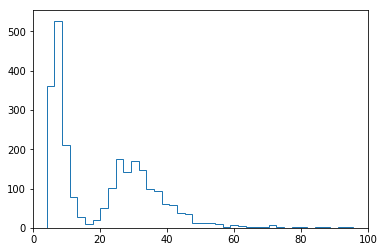

In [24]:
plt.hist(manager.results[manager.results < 100], histtype="step", bins=40)
plt.xlim(0, 100)

In [22]:
scores = sorted(zip(manager.gsa_result['delta'], manager.labels), reverse=True)
scores[:10]

[(0.4088898925971026, 'weekend_trip_gsa__transport_mode'),
 (0.06724776257637925,
  ('market for passenger car maintenance' (unit, GLO, None),
   'transport, passenger car, large size, diesel, EURO 5' (kilometer, RER, None))),
 (0.06516132119520882,
  ('market for passenger car, diesel' (kilogram, GLO, None),
   'transport, passenger car, large size, diesel, EURO 5' (kilometer, RER, None))),
 (0.06446535307484733, 'weekend_trip_gsa__vegetarian'),
 (0.06315970608366846,
  ('Peat, in ground' (kilogram, None, ('natural resource', 'biotic')),
   'cabbage white production' (kilogram, GLO, None))),
 (0.06197434335691315,
  ('Heat, waste' (megajoule, None, ('air',)),
   'tofu production' (kilogram, RoW, None))),
 (0.06167732449787583,
  ('Benzene' (kilogram, None, ('air', 'urban air close to ground')),
   'transport, passenger car, large size, diesel, EURO 5' (kilometer, RER, None))),
 (0.06121761502639841,
  ('Formaldehyde' (kilogram, None, ('air', 'urban air close to ground')),
   'transpor

Run it again to see how consistent the sensitivity scores are:

In [25]:
manager = GSAManager(mc, technosphere_exchanges, biosphere_exchanges, iterations=2500)

In [26]:
manager.calculate()

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:05:26
/Users/cmutel/miniconda3/envs/presamples/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [27]:
scores = sorted(zip(manager.gsa_result['delta'], manager.labels), reverse=True)
scores[:10]

[(0.41139221255793135, 'weekend_trip_gsa__transport_mode'),
 (0.1178304967401945,
  ('tofu production' (kilogram, RoW, None),
   'tofu production' (kilogram, RoW, None))),
 (0.11583369186631302,
  ('transport, passenger train, high-speed' (person kilometer, DE, None),
   'market for transport, passenger train' (person kilometer, GLO, None))),
 (0.1150589671758994,
  ('transport, passenger train, regional' (person kilometer, CH, None),
   'market for transport, passenger train' (person kilometer, GLO, None))),
 (0.11500642281395727,
  ('transport, passenger train, urban' (person kilometer, CH, None),
   'market for transport, passenger train' (person kilometer, GLO, None))),
 (0.11474181382800183,
  ('cattle for slaughtering, live weight to generic market for red meat, live weight' (kilogram, GLO, None),
   'market for red meat, live weight' (kilogram, GLO, None))),
 (0.1143665654736457,
  ('Zinc' (kilogram, None, ('soil', 'agricultural')),
   'cabbage white production' (kilogram, GLO, 

I'm not exactly sure why the values change so much, but I do think that everything after the first value is of basically no importance, but elevated due to some normalization step. See the paper for more details. We can also look at the Sobol' indices:

In [28]:
scores = sorted(zip(manager.gsa_result['S1'], manager.labels), reverse=True)
scores[:10]

[(0.46902881226569754, 'weekend_trip_gsa__transport_mode'),
 (0.013744027727544097, 'weekend_trip_gsa__hungry'),
 (0.012616170844591735,
  ('Toluene' (kilogram, None, ('air', 'urban air close to ground')),
   'transport, passenger car, large size, diesel, EURO 5' (kilometer, RER, None))),
 (0.011761938384005074,
  ('Selenium' (kilogram, None, ('air', 'urban air close to ground')),
   'transport, passenger car, large size, diesel, EURO 5' (kilometer, RER, None))),
 (0.01002087268103993,
  ('Difenoconazole' (kilogram, None, ('soil', 'agricultural')),
   'cabbage white production' (kilogram, GLO, None))),
 (0.009606310374690985,
  ('Transformation, from annual crop, irrigated, intensive' (square meter, None, ('natural resource', 'land')),
   'cabbage white production' (kilogram, GLO, None))),
 (0.009285364338887695,
  ('Acrolein' (kilogram, None, ('air', 'urban air close to ground')),
   'transport, passenger car, large size, diesel, EURO 5' (kilometer, RER, None))),
 (0.00907813363953619

And what the scores would be if we only considered the named parameters:

In [33]:
sorted(zip(
    analyze(manager.inputs[:, :4], manager.results)['delta'],
    manager.labels
), reverse=True)

/Users/cmutel/miniconda3/envs/presamples/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


[(0.4118237652037742, 'weekend_trip_gsa__transport_mode'),
 (0.11319685763499698, 'weekend_trip_gsa__vegetarian'),
 (0.10896917413373641, 'weekend_trip_gsa__food_consumed'),
 (0.10115802303137374, 'weekend_trip_gsa__hungry')]

In [34]:
sorted(zip(
    analyze(manager.inputs[:, :4], manager.results)['S1'],
    manager.labels
), reverse=True)

/Users/cmutel/miniconda3/envs/presamples/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


[(0.46902881226569754, 'weekend_trip_gsa__transport_mode'),
 (0.013744027727544097, 'weekend_trip_gsa__hungry'),
 (0.008893597279546042, 'weekend_trip_gsa__vegetarian'),
 (0.004405208986796312, 'weekend_trip_gsa__food_consumed')]